In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor,IsolationForest,ExtraTreesRegressor

from sklearn import preprocessing
import scoring as score # para hacer los reportes de puntajes
from time import time

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes

properati = pd.read_csv('datos/properati_final.csv')
zonas = pd.read_csv('datos/todos_los_barrios.csv')

<IPython.core.display.Javascript object>

In [39]:
#paso features con strings a numericos
le_zona = preprocessing.LabelEncoder()
properati['state_name'] =le_zona.fit_transform(properati['state_name'])

le_barrio = preprocessing.LabelEncoder()
le_barrio.fit(zonas.values)
properati['place_name'] = le_barrio.transform(properati['place_name'])

le_tipo = preprocessing.LabelEncoder()
properati['property_type'] = le_tipo.fit_transform(properati['property_type'])

In [40]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]
properati=properati.loc[properati.price_aprox_usd<1e7]
properati=properati.loc[properati.surface_covered_in_m2<7000]
print len(properati)
properati=properati.groupby("place_name").filter(lambda x: len(x)>5)
print len(properati)

136327
135917


In [41]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['place_name'])
y = properati["price_aprox_usd"]

In [43]:
Z= zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['place_name'],properati["price_aprox_usd"])

outs = IsolationForest(n_jobs=-1,n_estimators=50)
outs.fit(Z)

len(Z)

nuevo_aux =zip(X,outs.predict(Z)) 

nuevo=[tupla for tupla in nuevo_aux if tupla[1]==1] #solo necesito lo que devuelve predecir Z y no el Z en si
print len(nuevo)
nuevo=[tupla[0] for tupla in nuevo_aux]
X=nuevo

122322


# XGBoost

In [44]:
%%notify
from xgboost import XGBRegressor
xgb= XGBRegressor(nthread=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

learning_rate=np.arange(0.3,0.9,0.2)

param_grid = {"learning_rate": learning_rate,'min_child_weight':[1,3],'gamma':[i/10.0 for i in range(1,9)],'subsample':[i/10.0 for i in range(6,8)]}

search = RandomizedSearchCV(xgb, param_distributions=param_grid ,cv=5,n_iter=10) 
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


GridSearchCV duro 86.34 segundos para 10 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.789 (std: 0.002)
Promedio validation score: 0.695 (std: 0.013)
Promedio fit time: 1.208s
Hiper-parametros: {'subsample': 0.7, 'learning_rate': 0.69999999999999996, 'gamma': 0.8, 'min_child_weight': 3}

Puesto: 1
Promedio training score: 0.789 (std: 0.002)
Promedio validation score: 0.695 (std: 0.013)
Promedio fit time: 1.203s
Hiper-parametros: {'subsample': 0.7, 'learning_rate': 0.69999999999999996, 'gamma': 0.3, 'min_child_weight': 3}

Puesto: 3
Promedio training score: 0.782 (std: 0.003)
Promedio validation score: 0.690 (std: 0.019)
Promedio fit time: 1.327s
Hiper-parametros: {'subsample': 0.7, 'learning_rate': 0.5, 'gamma': 0.8, 'min_child_weight': 1}

Puesto: 4
Promedio training score: 0.771 (std: 0.005)
Promedio validation score: 0.684 (std: 0.013)
Promedio fit time: 1.207s
Hiper-parametros: {'subsample': 0.7, 'learning_rate': 0.5, 'gamma': 0.3, 'min_child_weight': 3}

Pue

<IPython.core.display.Javascript object>

In [45]:
xgboost = search.best_estimator_

# RF

In [46]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(40,100,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=2) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 40.94 segundos para 2 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.948 (std: 0.002)
Promedio validation score: 0.738 (std: 0.020)
Promedio fit time: 3.079s
Hiper-parametros: {'n_estimators': 70, 'max_features': 'auto', 'criterion': 'mse'}

Puesto: 2
Promedio training score: 0.946 (std: 0.002)
Promedio validation score: 0.733 (std: 0.021)
Promedio fit time: 2.342s
Hiper-parametros: {'n_estimators': 40, 'max_features': None, 'criterion': 'mse'}



<IPython.core.display.Javascript object>

In [47]:
rf= search.best_estimator_

In [15]:
search.score(X_test,y_test)

0.78551620775489417

# ETR

In [48]:
%%notify

etr = ExtraTreesRegressor(n_jobs=-1)

n_estimators = np.arange(40,100,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"n_estimators":n_estimators}

search = GridSearchCV(etr, param_grid=param_grid ,cv=5) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 196.51 segundos para 12 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.981 (std: 0.002)
Promedio validation score: 0.738 (std: 0.019)
Promedio fit time: 1.978s
Hiper-parametros: {'n_estimators': 70}

Puesto: 2
Promedio training score: 0.981 (std: 0.002)
Promedio validation score: 0.737 (std: 0.017)
Promedio fit time: 2.129s
Hiper-parametros: {'n_estimators': 75}

Puesto: 3
Promedio training score: 0.981 (std: 0.002)
Promedio validation score: 0.737 (std: 0.019)
Promedio fit time: 2.435s
Hiper-parametros: {'n_estimators': 85}

Puesto: 4
Promedio training score: 0.981 (std: 0.002)
Promedio validation score: 0.736 (std: 0.022)
Promedio fit time: 1.801s
Hiper-parametros: {'n_estimators': 60}

Puesto: 5
Promedio training score: 0.981 (std: 0.002)
Promedio validation score: 0.735 (std: 0.020)
Promedio fit time: 2.597s
Hiper-parametros: {'n_estimators': 95}

Puesto: 6
Promedio training score: 0.981 (std: 0.002)
Promedio validation score: 0.734 (std: 0.0

<IPython.core.display.Javascript object>

In [49]:
etr= search.best_estimator_

In [18]:
etr.feature_importances_

array([ 0.16253432,  0.64793845,  0.18952722])

# MLP

In [22]:
from sklearn.neural_network import MLPRegressor

In [23]:
%%notify

mlp = MLPRegressor()

activation = ["identity", "logistic", "tanh", "relu"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"activation": activation}

search = GridSearchCV(mlp, param_grid=param_grid ,cv=5,n_jobs=-1) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV duro 804.48 segundos para 4 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.493 (std: 0.072)
Promedio validation score: -0.121 (std: 1.035)
Promedio fit time: 105.808s
Hiper-parametros: {'activation': 'relu'}

Puesto: 2
Promedio training score: -0.527 (std: 0.059)
Promedio validation score: -0.576 (std: 0.140)
Promedio fit time: 93.532s
Hiper-parametros: {'activation': 'tanh'}

Puesto: 3
Promedio training score: -0.528 (std: 0.059)
Promedio validation score: -0.577 (std: 0.141)
Promedio fit time: 219.882s
Hiper-parametros: {'activation': 'logistic'}

Puesto: 4
Promedio training score: 0.161 (std: 0.131)
Promedio validation score: -0.904 (std: 2.015)
Promedio fit time: 41.417s
Hiper-parametros: {'activation': 'identity'}



/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<IPython.core.display.Javascript object>

In [24]:
mlp=search.best_estimator_

In [61]:
search.score(X_test,y_test)

0.79543121149897333

# Lineales

In [40]:
from sklearn.linear_model import LogisticRegression

In [ ]:
%%notify

logr = LogisticRegression(n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

logr.fit(X_train, y_train)
logr.score(X_test,y_test)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


# Ensamble

In [50]:
from mlxtend.regressor import StackingRegressor

stregr = StackingRegressor(regressors=[xgb,etr], 
                           meta_regressor=rf)

In [51]:
%%notify
stregr.fit(X_train,y_train)

StackingRegressor(meta_regressor=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         regressors=[XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight...stimators=70, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)],
         verbose=0)

<IPython.core.display.Javascript object>

In [67]:
stregr.score(X_test,y_test)

0.72001270439408871

In [53]:
errores = stregr.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:6873633.33333
Error minimo:0.0
52321     165553.571429
130981     95356.464291
65284    -169985.714286
118799     -5635.022449
65512      71022.709524
66477     469154.044898
33042       4203.699090
96107        113.533333
67806     -32827.568027
22232      62001.959476
44538      68166.904762
34264     -82267.755102
120143   -128136.241497
10147     -20007.695841
6353       46455.157065
83287      14817.207580
105737    -41835.623108
127245     15335.933333
136281     -4546.807074
94706      16429.792261
90285       8340.322769
60827      -8724.804762
28901     192332.557143
67789      74200.926407
17515      20778.320878
110849      1905.313239
134913     18834.945238
34321    -194058.888435
29808      45101.361025
27709    -104227.411855
              ...      
134532    -47888.664009
106645      1618.240043
59784      66505.742630
37208          0.000000
92590     -54440.043290
46862       -438.793396
111298         0.000000
31201      -3817.541904
110948     14634.719

In [54]:
count_max=0
max_error=10000
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 17176 de 27184 que tienen mas de 10000 USD de error (63%)


### Errores arriba del maximo

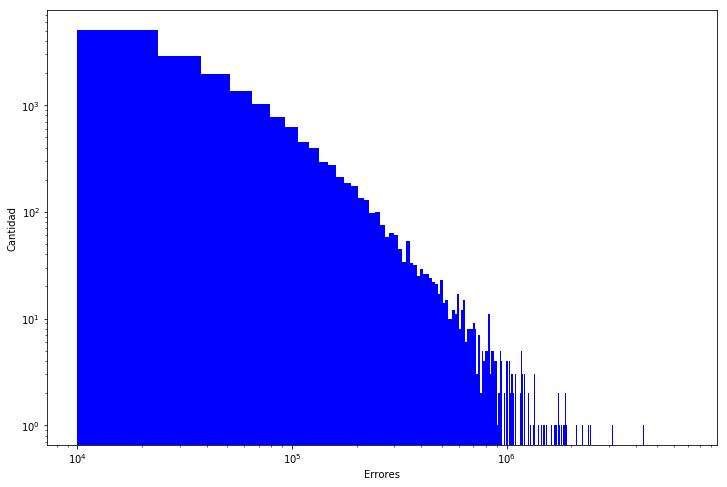

In [55]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(lista, 500, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-10000000, 10000000) #para variar el "zoom a 0"
plt.yscale('log')
plt.xscale('log')
plt.show()

### Errores totales

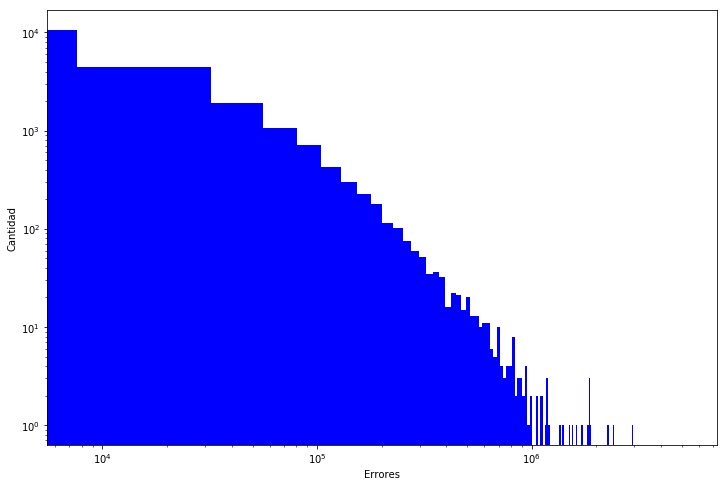

In [56]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 500, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-10000000, 10000000) #para variar el "zoom a 0"
plt.yscale('log')
plt.xscale('log')
plt.show()

# Kaggle

In [64]:
test_samples=pd.read_csv("datos/properati_dataset_testing_noprice_acondicionado.csv")
test_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 17 columns):
id                         14166 non-null int64
created_on                 14166 non-null object
property_type              14166 non-null object
operation                  14166 non-null object
place_name                 14166 non-null object
place_with_parent_names    14166 non-null object
country_name               14166 non-null object
state_name                 14166 non-null object
lat-lon                    10487 non-null object
lat                        10487 non-null float64
lon                        10487 non-null float64
surface_total_in_m2        14166 non-null float64
surface_covered_in_m2      14166 non-null float64
floor                      1368 non-null float64
rooms                      7500 non-null float64
expenses                   2543 non-null object
description                14166 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage: 1

In [65]:
test= zip(test_samples['surface_total_in_m2'],\
        test_samples['surface_covered_in_m2'],le_barrio.transform(test_samples['place_name']))

In [66]:
resultados = stregr.predict(test)
result=pd.DataFrame({'id':test_samples['id'],'price_usd':resultados})
result.to_csv('datos/resultados.csv',index=False)